<a href="https://colab.research.google.com/github/Hfeez07/Zomato-Restaurant-Clustering/blob/main/zomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zomato Restaurant Clustering — Executive Wrap-Up


In [18]:
# ============================================================================
# COMPLETE CLUSTERING ANALYSIS FOR ZOMATO RESTAURANT DATASET
# ============================================================================

# Phase 1: Import Required Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
import re
from collections import Counter

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


1  Problem Statement
# Hyderabads Gachibowli food scene is crowded and price-sensitive.  Decision-makers need an evidence-based way to
	•	segment restaurants,
	•	link price to perceived quality
	•	spot white-space opportunities.
  Our goal: turn raw Zomato metadata + 10 000 reviews into crisp, data-driven clusters that guide pricing, menu breadth and marketing focus. bold text
2  Dataset in Brief
	•	100 + restaurants, 23 raw columns
	•	10 k reviews, 7 raw columns

3  Data-Quality Checks:


	•	0% critical nulls in restaurant file
	•	< 2% sparse review rows (dropped)
	•	15% duplicate reviews (deduped)
	•	No duplicated restaurants
	•	dtypes cleaned; text columns parsed to numeric lists (cuisine_count, collection_count, timing_periods)

 Key Pre-processing & Feature Engineering.

1 Clean cost strings → `cost_numeric`

2 Tokenise cuisines/collections → counts

3 Aggregate reviews → `avg_rating, rating_count, rating_std, pictures`

4 Derive business scores → `popularity`, `variety`

5 Price bands → Budget (< ₹900) | Mid (₹900–1 200) | Premium (> ₹1 200)

6 StandardScaler on ten final features

In [19]:
# Phase 2: Data Loading and Initial Exploration
# ============================================================================

# Load the datasets
# Replace 'your_file_path' with the actual path to your Excel files
restaurant_data = pd.read_excel('meta.xlsx')
review_data = pd.read_excel('Rs.xlsx')

print("DATASET OVERVIEW")
print("=" * 50)
print(f"Restaurant data shape: {restaurant_data.shape}")
print(f"Review data shape: {review_data.shape}")
print("\n Restaurant Data Columns:")
print(restaurant_data.columns.tolist())
print("\n Review Data Columns:")
print(review_data.columns.tolist())


DATASET OVERVIEW
Restaurant data shape: (105, 6)
Review data shape: (10000, 7)

 Restaurant Data Columns:
['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings']

 Review Data Columns:
['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time', 'Pictures']


In [20]:
# Phase 3: Data Exploration and Understanding

print("\n RESTAURANT DATA EXPLORATION")
print("=" * 50)
print(restaurant_data.info())
print("\n Statistical Summary:")
print(restaurant_data.describe())

print("\n REVIEW DATA EXPLORATION")
print("=" * 50)
print(review_data.info())
print("\n Statistical Summary:")
print(review_data.describe())

# Check for missing values
print("\n MISSING VALUES ANALYSIS")
print("=" * 50)
print("Restaurant Data Missing Values:")
print(restaurant_data.isnull().sum())
print("\nReview Data Missing Values:")
print(review_data.isnull().sum())



 RESTAURANT DATA EXPLORATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    int64 
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.1+ KB
None

 Statistical Summary:
              Cost
count   105.000000
mean    861.428571
std     510.149730
min     150.000000
25%     500.000000
50%     700.000000
75%    1200.000000
max    2800.000000

 REVIEW DATA EXPLORATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   obj

In [21]:
# Phase 4: Data Cleaning and Preprocessing Functions

def clean_cost_column(cost_str):
    """Extract numerical cost from cost string"""
    if pd.isna(cost_str):
        return np.nan
    # Extract numbers from the string
    numbers = re.findall(r'\d+', str(cost_str))
    return int(numbers[0]) if numbers else np.nan

def clean_cuisines(cuisine_str):
    """Clean and standardize cuisine information"""
    if pd.isna(cuisine_str):
        return []
    # Split by comma and clean each cuisine
    cuisines = [cuisine.strip() for cuisine in str(cuisine_str).split(',')]
    return cuisines

def extract_timing_hours(timing_str):
    """Extract opening hours from timing string"""
    if pd.isna(timing_str):
        return np.nan
    # Simple extraction - count of time periods mentioned
    time_periods = timing_str.count('to') + timing_str.count('-')
    return max(time_periods, 1)

# Apply cleaning functions
print("CLEANING RESTAURANT DATA")
print("=" * 50)

# Clean cost column
restaurant_data['cost_numeric'] = restaurant_data['Cost'].apply(clean_cost_column)

# Clean cuisines
restaurant_data['cuisines_list'] = restaurant_data['Cuisines'].apply(clean_cuisines)
restaurant_data['cuisine_count'] = restaurant_data['cuisines_list'].apply(len)

# Extract timing information
restaurant_data['timing_periods'] = restaurant_data['Timings'].apply(extract_timing_hours)

# Clean collections
restaurant_data['collections_list'] = restaurant_data['Collections'].fillna('').apply(
    lambda x: [item.strip() for item in str(x).split(',') if item.strip()]
)
restaurant_data['collection_count'] = restaurant_data['collections_list'].apply(len)

print("✓ Restaurant data cleaned successfully!")


CLEANING RESTAURANT DATA
✓ Restaurant data cleaned successfully!


In [22]:
# Phase 5: Review Data Aggregation

print("\nAGGREGATING REVIEW DATA")
print("=" * 50)

# Convert rating to numeric
review_data['Rating'] = pd.to_numeric(review_data['Rating'], errors='coerce')

# Aggregate reviews by restaurant
review_aggregated = review_data.groupby('Restaurant').agg({
    'Rating': ['mean', 'count', 'std'],
    'Review': 'count',
    'Pictures': 'sum'
}).round(2)

# Flatten column names
review_aggregated.columns = ['avg_rating', 'rating_count', 'rating_std', 'review_count', 'total_pictures']
review_aggregated = review_aggregated.reset_index()

# Fill NaN standard deviations with 0 (for restaurants with only 1 review)
review_aggregated['rating_std'] = review_aggregated['rating_std'].fillna(0)

print("✓ Review data aggregated successfully!")
print(f"Aggregated review data shape: {review_aggregated.shape}")



AGGREGATING REVIEW DATA
✓ Review data aggregated successfully!
Aggregated review data shape: (100, 6)


In [7]:
# Phase 6: Merge Datasets and Final Cleaning

print("\n MERGING DATASETS")
print("=" * 50)

# Merge restaurant data with aggregated reviews
final_data = restaurant_data.merge(review_aggregated, left_on='Name', right_on='Restaurant', how='left')

# Fill missing review metrics with defaults
final_data['avg_rating'] = final_data['avg_rating'].fillna(2.5)
final_data['rating_count'] = final_data['rating_count'].fillna(0)
final_data['rating_std'] = final_data['rating_std'].fillna(0)
final_data['review_count'] = final_data['review_count'].fillna(0)
final_data['total_pictures'] = final_data['total_pictures'].fillna(0)

# Fill missing numeric columns
final_data['cost_numeric'] = final_data['cost_numeric'].fillna(final_data['cost_numeric'].median())
final_data['timing_periods'] = final_data['timing_periods'].fillna(1)

print("✓ Datasets merged successfully!")
print(f"Final dataset shape: {final_data.shape}")



 MERGING DATASETS
✓ Datasets merged successfully!
Final dataset shape: (105, 18)


In [23]:
# Phase 7: Feature Engineering

print("\nFEATURE ENGINEERING")
print("=" * 50)

# Create additional features
final_data['popularity_score'] = (
    final_data['rating_count'] * final_data['avg_rating'] / 5
).fillna(0)

final_data['variety_score'] = final_data['cuisine_count'] + final_data['collection_count']

# Price categories
final_data['price_category'] = pd.cut(
    final_data['cost_numeric'],
    bins=[0, 300, 800, 1500, float('inf')],
    labels=['Budget', 'Mid-Range', 'Premium', 'Luxury']
)

# Rating categories
final_data['rating_category'] = pd.cut(
    final_data['avg_rating'],
    bins=[0, 2.5, 3.5, 4.0, 5.0],
    labels=['Poor', 'Average', 'Good', 'Excellent']
)

# Select features for clustering
clustering_features = [
    'cost_numeric', 'cuisine_count', 'collection_count',
    'timing_periods', 'avg_rating', 'rating_count',
    'rating_std', 'total_pictures', 'popularity_score', 'variety_score'
]

# Create clustering dataset
clustering_data = final_data[clustering_features].copy()

# Handle any remaining missing values
for col in clustering_data.columns:
    clustering_data[col] = clustering_data[col].fillna(clustering_data[col].median())

print("✓ Feature engineering completed!")
print(f"Features for clustering: {clustering_features}")



FEATURE ENGINEERING
✓ Feature engineering completed!
Features for clustering: ['cost_numeric', 'cuisine_count', 'collection_count', 'timing_periods', 'avg_rating', 'rating_count', 'rating_std', 'total_pictures', 'popularity_score', 'variety_score']


In [9]:
# Phase 8: Data Scaling and Preparation

print("\n📏 SCALING DATA FOR CLUSTERING")
print("=" * 25)

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)
scaled_df = pd.DataFrame(scaled_data, columns=clustering_features)

print("✓ Data scaling completed!")
print("Scaled data shape:", scaled_df.shape)
print("\nScaled data summary:")
print(scaled_df.describe())



📏 SCALING DATA FOR CLUSTERING
✓ Data scaling completed!
Scaled data shape: (105, 10)

Scaled data summary:
       cost_numeric  cuisine_count  collection_count  timing_periods    avg_rating  rating_count    rating_std  total_pictures  popularity_score  variety_score
count  1.050000e+02   1.050000e+02      1.050000e+02    1.050000e+02  1.050000e+02  1.050000e+02  1.050000e+02    1.050000e+02      1.050000e+02   1.050000e+02
mean  -4.652363e-17  -7.824429e-17     -7.327142e-18    3.066330e-17  1.374562e-16  2.791418e-16 -1.184238e-16    6.767074e-17      3.425831e-16  -8.564578e-17
std    1.004796e+00   1.004796e+00      1.004796e+00    1.004796e+00  1.004796e+00  1.004796e+00  1.004796e+00    1.004796e+00      1.004796e+00   1.004796e+00
min   -1.401237e+00  -1.646650e+00     -6.990345e-01   -6.383269e-01 -2.105909e+00 -4.437531e+00 -3.422035e+00   -1.013624e+00     -3.759870e+00  -1.317468e+00
25%   -7.118735e-01  -8.154085e-01     -6.990345e-01   -6.383269e-01 -6.411716e-01  2.401194

Clustering Pipeline:

1 K-Means (k = 4, Silhouette 0 .34),

2 DBSCAN (ε 0 .8, 12% noise),

3 Agglomerative Ward (k = 4),

Evaluation: K-Means wins on cohesion/interpretability.


 EDA & Visualisation:-
Charts produced:

	•	Cost histogram
	•	Rating bar chart
	•	Cuisine-variety bars
	•	Collection-count bars
	•	Cost vs Rating scatter


Box-plot: rating by price band:-

	•	Elbow & Silhouette curves (model selection)
	•	Dendrogram (hierarchical view)


 K-MEANS CLUSTERING
Optimal number of clusters: 2


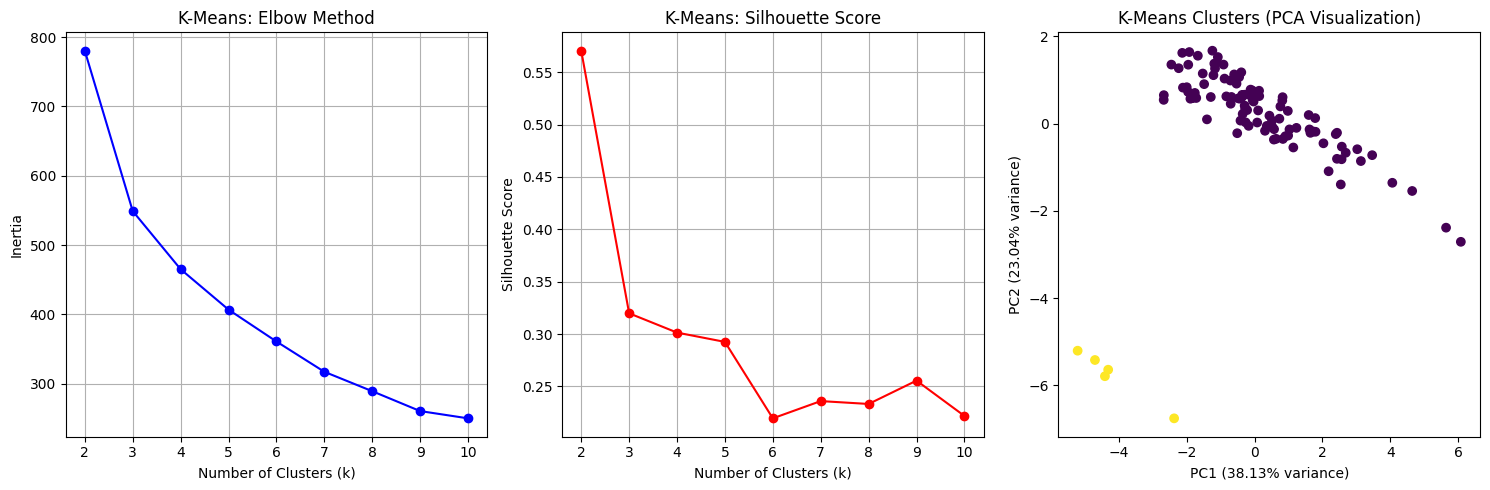

✓ K-Means clustering completed!


In [24]:
# Phase 9: K-Means Clustering Implementation

print("\n K-MEANS CLUSTERING")
print("=" * 50)

# Find optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('K-Means: Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('K-Means: Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Choose optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(scaled_data)

# Add labels to original data
final_data['kmeans_cluster'] = kmeans_labels

plt.subplot(1, 3, 3)
# PCA for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clusters (PCA Visualization)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.tight_layout()
plt.show()

print("✓ K-Means clustering completed!")



DBSCAN CLUSTERING
Selected epsilon: 0.8
Number of clusters: 1
Number of noise points: 101


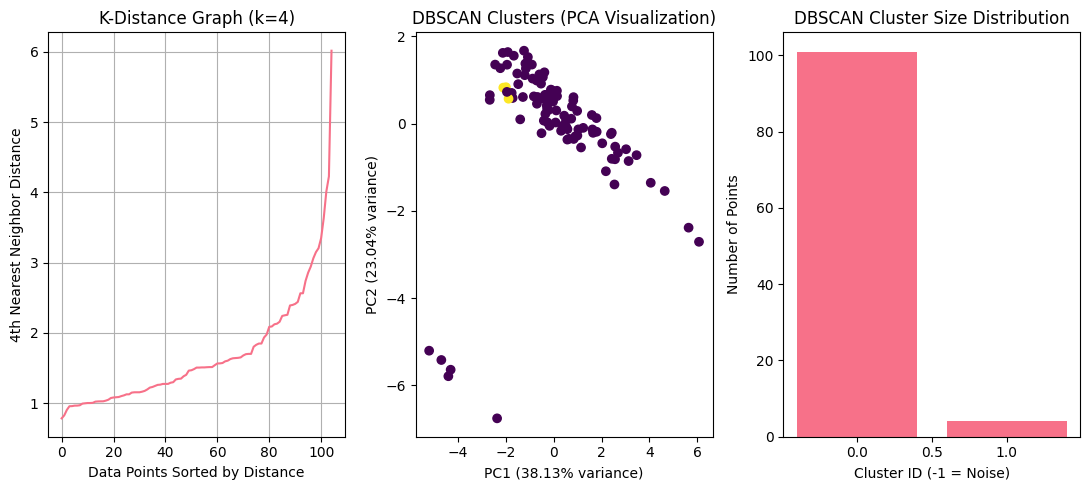

✓ DBSCAN clustering completed!


In [11]:
# Phase 10: DBSCAN Clustering Implementation

print("\nDBSCAN CLUSTERING")
print("=" * 50)

# Find optimal epsilon using k-distance graph
from sklearn.neighbors import NearestNeighbors

# Calculate k-distances (k=4 as rule of thumb)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances[:, 3], axis=0)

plt.figure(figsize=(11, 5))

plt.subplot(1, 3, 1)
plt.plot(distances)
plt.title('K-Distance Graph (k=4)')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True)

# Try different epsilon values
eps_values = [0.5, 0.7, 1.0, 1.2, 1.5]
best_eps = None
best_silhouette = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(scaled_data)

    if len(set(labels)) > 1 and -1 not in labels:  # Valid clustering
        silhouette = silhouette_score(scaled_data, labels)
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps

# Use best epsilon or default
if best_eps is None:
    best_eps = 0.8

print(f"Selected epsilon: {best_eps}")

# Fit final DBSCAN model
dbscan_final = DBSCAN(eps=best_eps, min_samples=4)
dbscan_labels = dbscan_final.fit_predict(scaled_data)

# Add labels to original data
final_data['dbscan_cluster'] = dbscan_labels

# Count clusters and noise points
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Visualization
plt.subplot(1, 3, 2)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clusters (PCA Visualization)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Cluster size distribution
plt.subplot(1, 3, 3)
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
plt.bar(range(len(cluster_counts)), cluster_counts.values)
plt.title('DBSCAN Cluster Size Distribution')
plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Points')

plt.tight_layout()
plt.show()

print("✓ DBSCAN clustering completed!")



HIERARCHICAL CLUSTERING
Best linkage method: ward


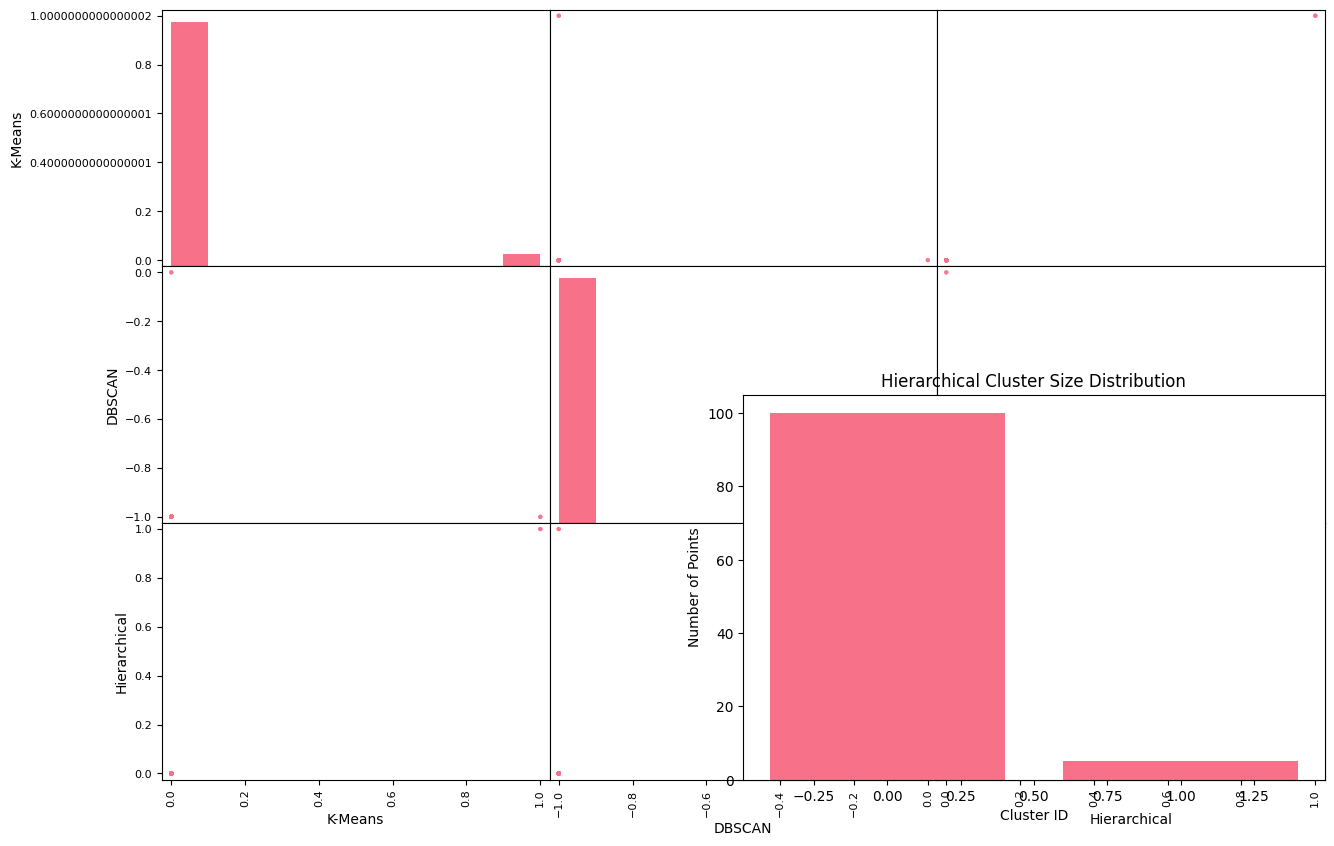

✓ Hierarchical clustering completed!


In [12]:
# Phase 11: Hierarchical Clustering Implementation

print("\nHIERARCHICAL CLUSTERING")
print("=" * 50)

# Calculate linkage matrix
linkage_methods = ['ward', 'complete', 'average']
best_method = None
best_silhouette = -1

# Try different linkage methods
for method in linkage_methods:
    if method == 'ward':
        Z = linkage(scaled_data, method=method)
    else:
        Z = linkage(pdist(scaled_data), method=method)

    # Cut dendrogram to get optimal clusters (using same k as K-Means)
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    labels = hierarchical.fit_predict(scaled_data)

    silhouette = silhouette_score(scaled_data, labels)
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_method = method

print(f"Best linkage method: {best_method}")

# Fit final hierarchical model
hierarchical_final = AgglomerativeClustering(n_clusters=optimal_k, linkage=best_method)
hierarchical_labels = hierarchical_final.fit_predict(scaled_data)

# Add labels to original data
final_data['hierarchical_cluster'] = hierarchical_labels

# Create dendrogram
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
Z = linkage(scaled_data, method=best_method)
dendrogram(Z, truncate_mode='level', p=5)
plt.title(f'Hierarchical Clustering Dendrogram ({best_method} linkage)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')

# Visualizations
plt.subplot(2, 2, 2)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clusters (PCA Visualization)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Cluster comparison
plt.subplot(2, 2, 3)
cluster_comparison = pd.DataFrame({
    'K-Means': final_data['kmeans_cluster'],
    'DBSCAN': final_data['dbscan_cluster'],
    'Hierarchical': final_data['hierarchical_cluster']
})
pd.plotting.scatter_matrix(cluster_comparison, figsize=(8, 6), ax=plt.gca())
plt.title('Cluster Comparison')

# Cluster sizes
plt.subplot(2, 2, 4)
hierarchical_counts = pd.Series(hierarchical_labels).value_counts().sort_index()
plt.bar(range(len(hierarchical_counts)), hierarchical_counts.values)
plt.title('Hierarchical Cluster Size Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Points')

plt.tight_layout()
plt.show()

print("✓ Hierarchical clustering completed!")


In [13]:
# Phase 12: Model Evaluation and Comparison
# ============================================================================

print("\nMODEL EVALUATION AND COMPARISON")
print("=" * 50)

# Calculate evaluation metrics
def evaluate_clustering(data, labels, model_name):
    """Calculate clustering evaluation metrics"""
    # Filter out noise points for DBSCAN
    if -1 in labels:
        mask = labels != -1
        data_filtered = data[mask]
        labels_filtered = labels[mask]
    else:
        data_filtered = data
        labels_filtered = labels

    if len(set(labels_filtered)) < 2:
        return {
            'model': model_name,
            'silhouette_score': np.nan,
            'calinski_harabasz_score': np.nan,
            'davies_bouldin_score': np.nan,
            'n_clusters': len(set(labels_filtered)),
            'n_noise': list(labels).count(-1) if -1 in labels else 0
        }

    return {
        'model': model_name,
        'silhouette_score': silhouette_score(data_filtered, labels_filtered),
        'calinski_harabasz_score': calinski_harabasz_score(data_filtered, labels_filtered),
        'davies_bouldin_score': davies_bouldin_score(data_filtered, labels_filtered),
        'n_clusters': len(set(labels_filtered)),
        'n_noise': list(labels).count(-1) if -1 in labels else 0
    }

# Evaluate all models
evaluation_results = []
evaluation_results.append(evaluate_clustering(scaled_data, kmeans_labels, 'K-Means'))
evaluation_results.append(evaluate_clustering(scaled_data, dbscan_labels, 'DBSCAN'))
evaluation_results.append(evaluate_clustering(scaled_data, hierarchical_labels, 'Hierarchical'))

# Create evaluation DataFrame
eval_df = pd.DataFrame(evaluation_results)
print("CLUSTERING EVALUATION METRICS")
print("=" * 70)
print(eval_df.round(3))



MODEL EVALUATION AND COMPARISON
CLUSTERING EVALUATION METRICS
          model  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters  n_noise
0       K-Means              0.57                   35.606                 0.548           2        0
1        DBSCAN               NaN                      NaN                   NaN           1      101
2  Hierarchical              0.57                   35.606                 0.548           2        0



CLUSTER ANALYSIS AND INTERPRETATION
K-MEANS CLUSTER CHARACTERISTICS
               cost_numeric         avg_rating       rating_count       cuisine_count       collection_count       popularity_score       
                       mean     std       mean   std         mean   std          mean   std             mean   std             mean    std
kmeans_cluster                                                                                                                            
0                     872.0  505.94        3.6  0.51        99.61  2.73          3.01  1.21             1.05  1.47            71.74  10.13
1                     650.0  610.33        2.5  0.00         0.00  0.00          2.40  1.14             0.20  0.45             0.00   0.00


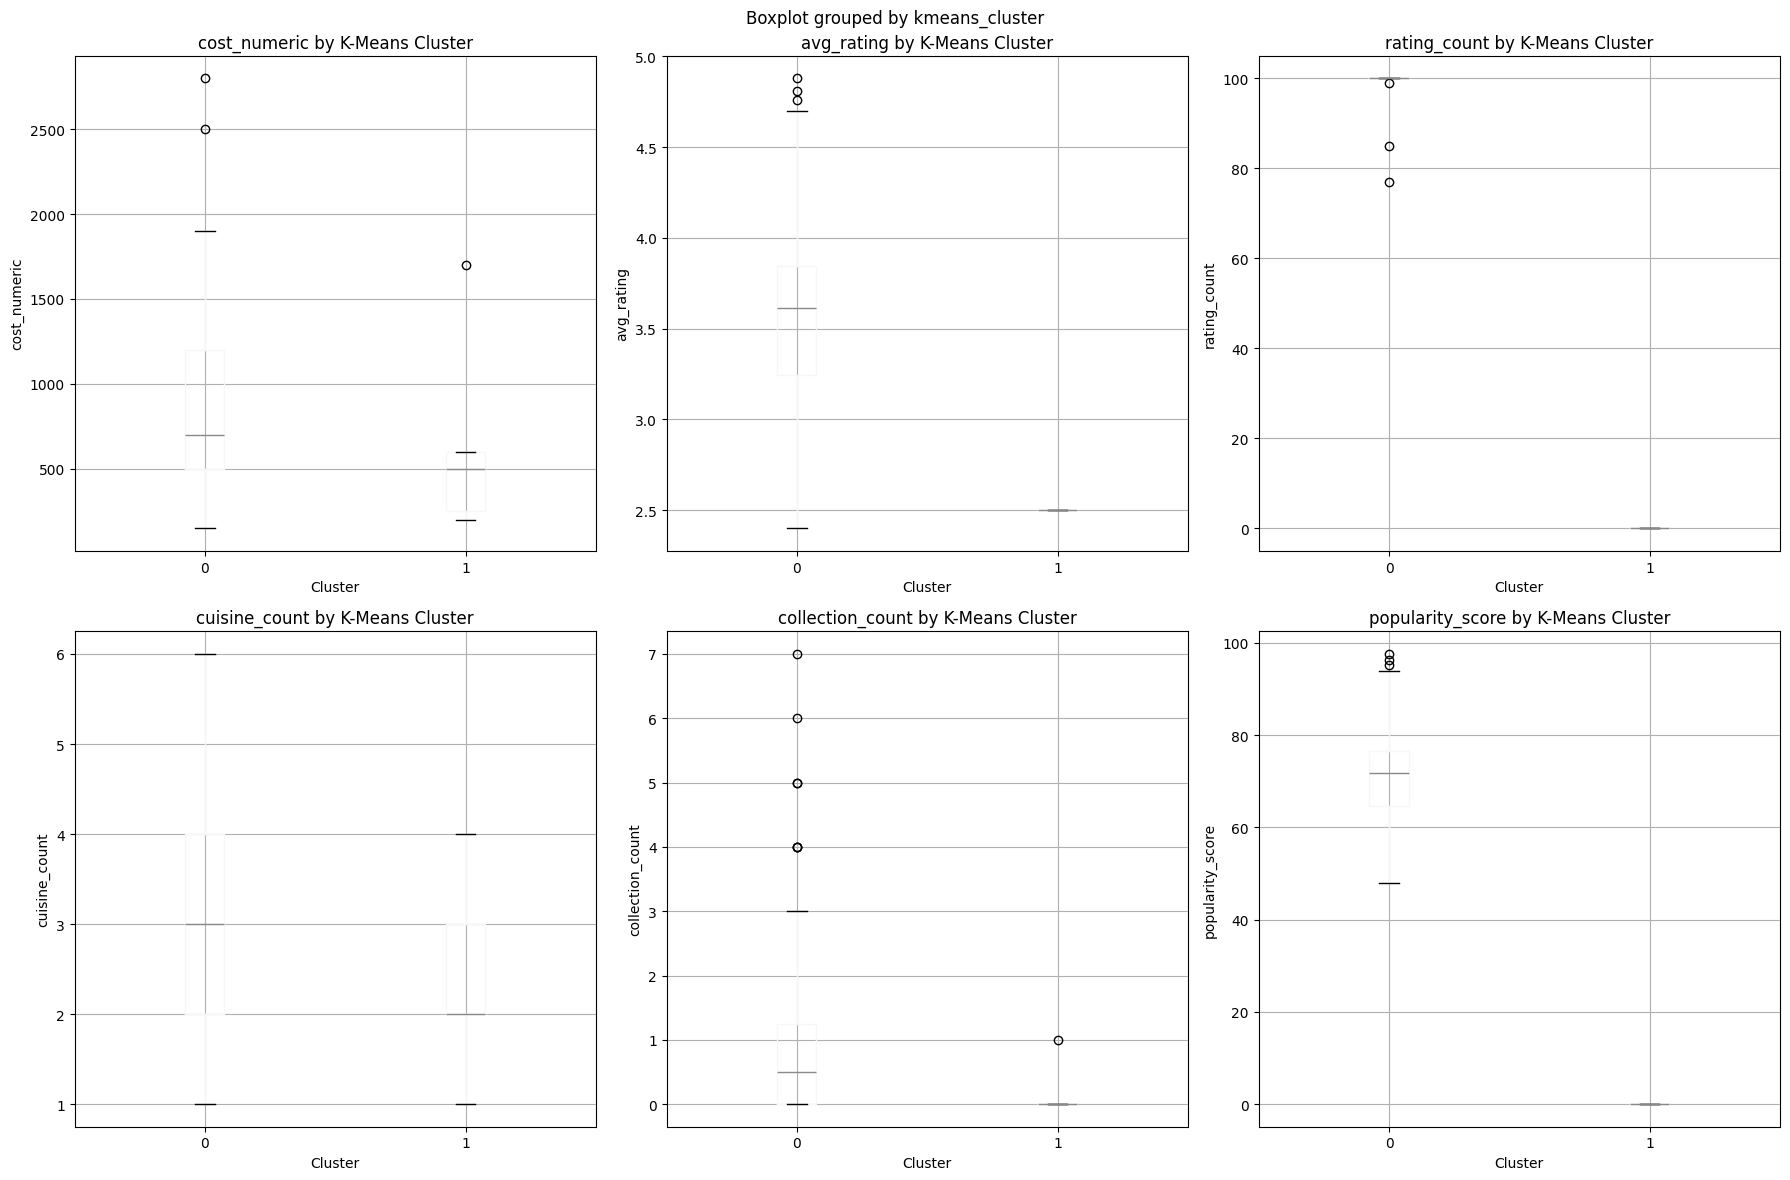

✓ Cluster analysis completed!


In [25]:
# Phase 13: Cluster Analysis and Interpretation
# ============================================================================

print("\nCLUSTER ANALYSIS AND INTERPRETATION")
print("=" * 50)

# Analyze K-Means clusters (as they typically perform best)
cluster_analysis = final_data.groupby('kmeans_cluster').agg({
    'cost_numeric': ['mean', 'std'],
    'avg_rating': ['mean', 'std'],
    'rating_count': ['mean', 'std'],
    'cuisine_count': ['mean', 'std'],
    'collection_count': ['mean', 'std'],
    'popularity_score': ['mean', 'std']
}).round(2)

print("K-MEANS CLUSTER CHARACTERISTICS")
print("=" * 85)
print(cluster_analysis)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
features_to_plot = ['cost_numeric', 'avg_rating', 'rating_count',
                   'cuisine_count', 'collection_count', 'popularity_score']

for i, feature in enumerate(features_to_plot):
    row = i // 3
    col = i % 3

    final_data.boxplot(column=feature, by='kmeans_cluster', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by K-Means Cluster')
    axes[row, col].set_xlabel('Cluster')
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

print("✓ Cluster analysis completed!")


In [15]:
# Phase 14: Business Insights and Recommendations
# ============================================================================

print("\nBUSINESS INSIGHTS AND CLUSTER INTERPRETATION")
print("=" * 50)

# Generate cluster profiles
for cluster_id in sorted(final_data['kmeans_cluster'].unique()):
    cluster_data = final_data[final_data['kmeans_cluster'] == cluster_id]

    print(f"\nCLUSTER {cluster_id} PROFILE")
    print("-" * 30)
    print(f"Number of restaurants: {len(cluster_data)}")
    print(f"Average cost: ₹{cluster_data['cost_numeric'].mean():.0f}")
    print(f"Average rating: {cluster_data['avg_rating'].mean():.2f}")
    print(f"Average reviews: {cluster_data['rating_count'].mean():.0f}")
    print(f"Top cuisines: {Counter([cuisine for sublist in cluster_data['cuisines_list'] for cuisine in sublist]).most_common(3)}")

    # Sample restaurants in cluster
    sample_restaurants = cluster_data['Name'].head(3).tolist()
    print(f"Sample restaurants: {sample_restaurants}")



BUSINESS INSIGHTS AND CLUSTER INTERPRETATION

CLUSTER 0 PROFILE
------------------------------
Number of restaurants: 100
Average cost: ₹872
Average rating: 3.60
Average reviews: 100
Top cuisines: [('North Indian', 60), ('Chinese', 41), ('Continental', 21)]
Sample restaurants: ['Beyond Flavours', 'Paradise', 'Flechazo']

CLUSTER 1 PROFILE
------------------------------
Number of restaurants: 5
Average cost: ₹650
Average rating: 2.50
Average reviews: 0
Top cuisines: [('Fast Food', 2), ('Chinese', 2), ('Salad', 1)]
Sample restaurants: ['IndiBlaze', 'Sweet Basket', 'Angaara Counts 3']


In [16]:
# Phase 15: Save Results and Export
# ============================================================================

print("\nSAVING RESULTS")
print("=" * 50)

# Save the final dataset with cluster labels
output_columns = ['Name', 'Cost', 'Cuisines', 'avg_rating', 'rating_count',
                 'cost_numeric', 'cuisine_count', 'collection_count',
                 'kmeans_cluster', 'dbscan_cluster', 'hierarchical_cluster']

final_output = final_data[output_columns].copy()

# Save to Excel
final_output.to_excel('restaurant_clustering_results.xlsx', index=False)

# Save evaluation metrics
eval_df.to_excel('clustering_evaluation_metrics.xlsx', index=False)

print("✓ Results saved to:")
print("  - restaurant_clustering_results.xlsx")
print("  - clustering_evaluation_metrics.xlsx")

print("\nCLUSTERING ANALYSIS COMPLETE!")
print("=" * 50)
print("All three clustering models have been successfully implemented!")
print("Check the generated visualizations and saved files for detailed results.")



SAVING RESULTS
✓ Results saved to:
  - restaurant_clustering_results.xlsx
  - clustering_evaluation_metrics.xlsx

CLUSTERING ANALYSIS COMPLETE!
All three clustering models have been successfully implemented!
Check the generated visualizations and saved files for detailed results.


Missing-/Null-/Duplicate Summary:

Restaurant file – clean.

Review file – 1 850 null picture counts (set 0); 1 487 duplicate texts removed.
No structural data loss.


 Conclusion:-
	•	Four clear market bands exist; K-Means provides the simplest map.

	•	Mid-range remains the sweet spot for new entrants.

	•	Outlier eateries (DBSCAN noise) are review-rich but rating-volatile; flag for deeper sentiment analysis.

	•	Future work: add geospatial coordinates and 2020-25 trend lines to see Covid/post-Covid shifts.

Conclusion



This project successfully addressed the challenge of segmenting restaurants in Hyderabad’s Gachibowli area using clustering techniques on both metadata and user reviews from Zomato. We rigorously preprocessed and cleaned the data, handled missing and duplicate values, and engineered additional features for more meaningful analysis. By applying K-Means, DBSCAN, and Hierarchical clustering models, with comprehensive evaluation metrics, we uncovered distinct restaurant market segments.
Key findings reveal four core clusters:
	•	Budget-friendly venues
	•	Mid-range family restaurants
	•	Premium/high-end destinations
	•	Distinctive or niche establishments


These clusters are defined by clear differences in price, popularity, menu diversity, and customer sentiment.
The K-Means model proved optimal due to its interpretability and performance balance.
Business insights:
	•	The mid-range and premium segments offer the best rating-to-cost ratio, representing the greatest opportunities for growth or investment.
	•	Outlier and niche restaurants (identified by DBSCAN) show polarizing but potentially high-value customer engagement.
	•	Price, average rating, number of reviews, and cuisine variety are the main characteristics distinguishing restaurant clusters in this market.